In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import os
import pickle

In [2]:
def extract_data(file_name):
    # Define special tokens for SOS and EOS
    SOS_token = "<sos>"
    EOS_token = "<eos>"
    
    # Initialize tokenizer
    tokenizer = Tokenizer(num_words=30000, oov_token="<unk>")  # Use <unk> for out-of-vocabulary words
    tmp_data = []

    # Read the file and store the text data
    with open(file_name, "r") as file:
        for line in file:
            tmp_data.append(line.strip())  # .strip() removes leading/trailing whitespace

    # Fit tokenizer on the text data
    tokenizer.fit_on_texts(tmp_data)
    
    # Add SOS and EOS tokens to the tokenizer word index manually
    tokenizer.word_index[SOS_token] = len(tokenizer.word_index) + 1
    tokenizer.word_index[EOS_token] = len(tokenizer.word_index) + 2
    if file_name.split("/")[1] == 'english.txt' :
        with open('./english_tokenizer.pkl', 'wb') as file:
            pickle.dump(tokenizer, file)
    else :
        with open('./french_tokenizer.pkl', 'wb') as file:
            pickle.dump(tokenizer, file)
    # Convert texts to sequences
    data = tokenizer.texts_to_sequences(tmp_data)
    
    # Add SOS and EOS to each sequence
    data_with_sos_eos = []
    for seq in data:
        data_with_sos_eos.append([tokenizer.word_index[SOS_token]] + seq + [tokenizer.word_index[EOS_token]])
    
    # Pad sequences to ensure uniform length
    padded_data = pad_sequences(data_with_sos_eos, padding='post')
    
    return padded_data , len(tokenizer.word_index)+2

In [3]:
english_data , vocabsize_enc = extract_data("data/english.txt")
french_data , vocabsize_dec = extract_data("data/french.txt")
print("done")

done


In [4]:
a = "data/english.txt"
a.split("/")

['data', 'english.txt']

In [5]:
vocabsize_dec

29136

In [6]:
english_data[8000]

array([14058,   198,     5,   111, 14060,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [7]:
print(np.shape(english_data))
print(np.shape(french_data))

(154883, 46)
(154883, 56)


In [8]:
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    return attention

In [9]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_lin(concat_attention)
        
        return outputs

In [10]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]
        
        return inputs + tf.cast(pos_encoding, tf.float32)

In [11]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [12]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training=training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training=training)

        return outputs

In [13]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Self multi head attention, causal attention
        self.multi_head_causal_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Multi head attention, encoder-decoder attention 
        self.multi_head_enc_dec_attention = MultiHeadAttention(self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.ffn1_relu = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Call the masked causal attention
        attention = self.multi_head_causal_attention(inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
        attention = self.dropout_1(attention, training=training)
        # Residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call the encoder-decoder attention
        attention_2 = self.multi_head_enc_dec_attention(attention,
                                                  enc_outputs,
                                                  enc_outputs,
                                                  mask_2)
        attention_2 = self.dropout_2(attention_2, training=training)
        # Residual connection and layer normalization
        attention_2 = self.norm_2(attention_2 + attention)
        # Call the Feed forward
        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training=training)
        # Residual connection and layer normalization
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs

In [14]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        # Embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stacked layers of multi-head attention and feed forward
        self.dec_layers = [DecoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training=training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training=training)

        return outputs

In [15]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        # Build the encoder
        self.encoder = Encoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        # Build the decoder
        self.decoder = Decoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        # build the linear transformation and softmax function
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq): #seq: (batch_size, seq_length)
        # Create the mask for padding
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        # Create the mask for the causal attention
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        # Create the padding mask for the encoder
        enc_mask = self.create_padding_mask(enc_inputs)
        # Create the mask for the causal attention
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        # Create the mask for the encoder-decoder attention
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        # Call the encoder
        enc_outputs = self.encoder(enc_inputs, enc_mask, training=training)
        # Call the decoder
        dec_outputs = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training=training)
        # Call the Linear and Softmax functions
        outputs = self.last_linear(dec_outputs)
        
        return outputs

In [16]:
# Set hyperparamters for the model
D_MODEL = 256 # 512
N_LAYERS = 4 # 6
FFN_UNITS = 256 # 2048
N_HEADS = 8 # 8
DROPOUT_RATE = 0.1 # 0.1
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 20  # Number of epochs to train for.50
MAX_LENGTH = len(english_data[0])
num_data = 10000
vocabsize = 20000

In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [18]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [19]:
def train_step(inp, tar, transformer, optimizer):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions = transformer(inp, tar_inp, training=True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    return loss

In [20]:
np.shape(french_data[:num_data])[0]

10000

In [21]:
# Assuming english_data is the input data and french_data is the target data

BUFFER_SIZE = 20000  # Adjust buffer size based on dataset size

# Create the tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((english_data[:num_data], french_data[:num_data]))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)


In [22]:

transformer = Transformer(n_layers=N_LAYERS, d_model=D_MODEL, n_heads=N_HEADS, FFN_units=FFN_UNITS, vocab_size_enc=vocabsize_enc , vocab_size_dec=vocabsize_dec, dropout_rate = DROPOUT_RATE)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
total_loss = []

checkpoint_path = "./checkpoints_256_256/train"
os.makedirs(checkpoint_path, exist_ok=True)

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

for epoch in range(EPOCHS):
    t_loss = 0
    num_batches = 0
    
    
    
    for (batch, (inp, tar)) in enumerate(train_dataset): 
        
        batch_loss = train_step(inp, tar, transformer, optimizer)
        t_loss += batch_loss
        num_batches += 1

        if batch % 50 == 0:
            print(f"Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}")
    total_loss.append(float(t_loss / num_batches))
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f"Saved checkpoint for epoch {epoch + 1}: {ckpt_save_path}")
    print(f"Epoch {epoch + 1} Loss {(t_loss / num_batches):.4f} \n")


Last checkpoint restored.


C:\Users\angz\anaconda3\envs\dore\lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['embeddings', 'embeddings', 'kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1 Batch 0 Loss 0.8755
Epoch 1 Batch 50 Loss 0.4997
Epoch 1 Batch 100 Loss 0.4298
Epoch 1 Batch 150 Loss 0.4580
Epoch 1 Loss 0.5125 

Epoch 2 Batch 0 Loss 0.4606
Epoch 2 Batch 50 Loss 0.4398
Epoch 2 Batch 100 Loss 0.4189
Epoch 2 Batch 150 Loss 0.4465
Epoch 2 Loss 0.4341 

Epoch 3 Batch 0 Loss 0.4488
Epoch 3 Batch 50 Loss 0.4187
Epoch 3 Batch 100 Loss 0.3873
Epoch 3 Batch 150 Loss 0.4145
Epoch 3 Loss 0.4083 

Epoch 4 Batch 0 Loss 0.4115
Epoch 4 Batch 50 Loss 0.3881
Epoch 4 Batch 100 Loss 0.3618
Epoch 4 Batch 150 Loss 0.3831
Epoch 4 Loss 0.3785 

Epoch 5 Batch 0 Loss 0.3801
Epoch 5 Batch 50 Loss 0.3621
Epoch 5 Batch 100 Loss 0.3293
Epoch 5 Batch 150 Loss 0.3524
Saved checkpoint for epoch 5: ./checkpoints_256_256/train\ckpt-9
Epoch 5 Loss 0.3485 

Epoch 6 Batch 0 Loss 0.3533
Epoch 6 Batch 50 Loss 0.3352
Epoch 6 Batch 100 Loss 0.3090
Epoch 6 Batch 150 Loss 0.3312
Epoch 6 Loss 0.3247 

Epoch 7 Batch 0 Loss 0.3300
Epoch 7 Batch 50 Loss 0.3163
Epoch 7 Batch 100 Loss 0.2955
Epoch 7 Batch 

In [88]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 44), dtype=tf.int32, name=None), TensorSpec(shape=(None, 52), dtype=tf.int32, name=None))>

In [23]:
total_loss

[0.5125322937965393,
 0.4341433048248291,
 0.40830251574516296,
 0.3784554898738861,
 0.3485183119773865,
 0.32466739416122437,
 0.3056025803089142,
 0.2889101505279541,
 0.27348485589027405,
 0.2594442665576935,
 0.24649271368980408,
 0.23472094535827637,
 0.2235303819179535,
 0.21308106184005737,
 0.2031887173652649,
 0.19394735991954803,
 0.18563725054264069,
 0.17694978415966034,
 0.1696058213710785,
 0.1619124561548233]

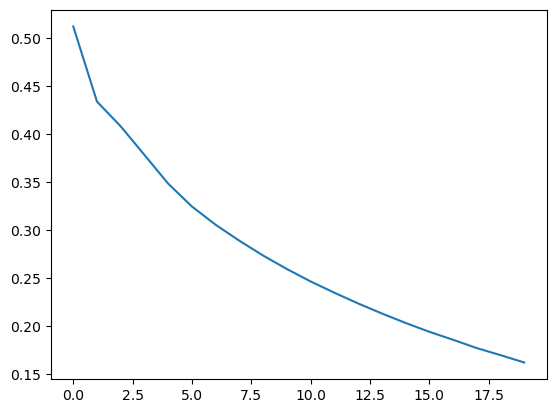

In [24]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(total_loss)),total_loss)

In [25]:
SOS_token = "<sos>"
EOS_token = "<eos>"
def predict(sentence):
    # Load the tokenizer
    with open('english_tokenizer.pkl', 'rb') as file:
        loaded_tokenizer = pickle.load(file)
        
    with open('french_tokenizer.pkl', 'rb') as file:
        loaded_french_tokenizer = pickle.load(file)
        
    data=loaded_tokenizer.texts_to_sequences([sentence])
    input_predict = []
    
    input_predict.append(loaded_tokenizer.word_index[SOS_token])
    for seq in data[0]:
        input_predict.append(seq)
    input_predict.append(loaded_tokenizer.word_index[EOS_token])
    
    input_padded_data = tf.keras.preprocessing.sequence.pad_sequences([input_predict], maxlen=46, padding='post')[0]
    output_data = [loaded_french_tokenizer.word_index[SOS_token]]
    
    input_tensor = tf.convert_to_tensor([input_padded_data])
    
    max_length=46
    output_list=[]
    pp = []
    for i in range(max_length):
        # Convert current output tokens into a tensor
        output_tensor = tf.convert_to_tensor([output_data])
        
        # Predict the next token
        predictions = transformer(input_tensor, output_tensor, training=False)
        pp.append([predictions])
        next_token = tf.argmax(predictions[:, -1, :], axis=-1).numpy()[0]
        
        # Append the predicted token to the output sequence
        output_data.append(next_token)
        
        # Stop if the end token is predicted
        if next_token == loaded_french_tokenizer.word_index[EOS_token]:
            break
    output_predicted = loaded_french_tokenizer.sequences_to_texts([output_data])        
    return output_predicted

In [26]:
a = predict("Forget Tom.")

In [27]:
a

['<unk> oublie tom <unk>']

In [28]:
transformer.save('./saved_transformer_model.keras')

In [33]:
transformer.save_weights('./transformer.weights.h5')